# Assessed Coursework Template Notebook

This is the template notebook for the RecSys(H) 2020 coursework. It deals with data preparation and evaluation only.

Please note:
 - use H1 text headings for grouping together blocks of cells. You can then hide these while working on other blocks
 - leave the cell output visible when you submit the notebook



## Setup block

Setup the data files, Python etc.

In [0]:
!rm -rf ratings* books* to_read* test*

!curl -o ratings.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-ratings.csv" 
!curl -o books.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-books.csv"
!curl -o to_read.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-to_read.csv"
!curl -o test.csv "http://www.dcs.gla.ac.uk/~craigm/recsysH/coursework/final-test.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7631k  100 7631k    0     0  1749k      0  0:00:04  0:00:04 --:--:-- 1749k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2366k  100 2366k    0     0   611k      0  0:00:03  0:00:03 --:--:--  611k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7581k  100 7581k    0     0  2235k      0  0:00:03  0:00:03 --:--:-- 2235k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1895k  100 1895k    0     0   655k      0  0:00:02  0:00:02 --:--:--  654k


In [0]:
#Standard setup
import pandas as pd
import numpy as np
import torch
!pip install git+https://github.com/cmacdonald/spotlight.git@master#egg=spotlight
from spotlight.interactions import Interactions


  Cloning https://github.com/cmacdonald/spotlight.git (to revision master) to /tmp/pip-install-coirnecr/spotlight
  Running command git clone -q https://github.com/cmacdonald/spotlight.git /tmp/pip-install-coirnecr/spotlight
  Created wheel for spotlight: filename=spotlight-0.1.6-cp36-none-any.whl size=34096 sha256=07eaacd69d495c62c18b62e6e7f6dfc41d7724606536e88c5a1bd55e84acb870
  Stored in directory: /tmp/pip-ephem-wheel-cache-0_n4d528/wheels/22/6f/f1/68cc6c5b563e78737e4a8fed63ddc105a3baf25d2abccae0c6
Successfully built spotlight


# data preparation

In [0]:
#load in the csv files
ratings_df = pd.read_csv("ratings.csv")
books_df = pd.read_csv("books.csv")
to_read_df = pd.read_csv("to_read.csv")
test = pd.read_csv("test.csv")

In [0]:
#cut down the number of items and users
counts=ratings_df[ratings_df["book_id"] < 2000].groupby(["book_id"]).count().reset_index()
valid_books=counts[counts["user_id"] >= 10][["book_id"]]

books_df = books_df.merge(valid_books, on="book_id")

ratings_df = ratings_df[ratings_df["user_id"] < 2000].merge(valid_books, on="book_id")
to_read_df = to_read_df[to_read_df["user_id"] < 2000].merge(valid_books, on="book_id")
test = test[test["user_id"] < 2000].merge(valid_books, on="book_id")


Here we construct the Interactions objects from `ratings.csv`, `to_read.csv` and `test.csv`. We manually specify the num_users and num_items parameters to all Interaction objects, in case the test set differs from your training sets.

In [0]:
from collections import defaultdict
from itertools import count

from spotlight.cross_validation import random_train_test_split

iid_map = defaultdict(count().__next__)


rating_iids = np.array([iid_map[iid] for iid in ratings_df["book_id"].values], dtype = np.int32)
test_iids = np.array([iid_map[iid] for iid in test["book_id"].values], dtype = np.int32)
toread_iids = np.array([iid_map[iid] for iid in to_read_df["book_id"].values], dtype = np.int32)


uid_map = defaultdict(count().__next__)
test_uids = np.array([uid_map[uid] for uid in test["user_id"].values], dtype = np.int32)
rating_uids = np.array([uid_map[uid] for uid in ratings_df["user_id"].values], dtype = np.int32)
toread_uids = np.array([uid_map[iid] for iid in to_read_df["user_id"].values], dtype = np.int32)


uid_rev_map = {v: k for k, v in uid_map.items()}
iid_rev_map = {v: k for k, v in iid_map.items()}


rating_dataset = Interactions(user_ids=rating_uids,
                               item_ids=rating_iids,
                               ratings=ratings_df["rating"].values,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

toread_dataset = Interactions(user_ids=toread_uids,
                               item_ids=toread_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

test_dataset = Interactions(user_ids=test_uids,
                               item_ids=test_iids,
                               num_users=len(uid_rev_map),
                               num_items=len(iid_rev_map))

print(rating_dataset)
print(toread_dataset)
print(test_dataset)

#here we define the validation set
#toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.seed(42))
toread_dataset_train, validation = random_train_test_split(toread_dataset, random_state=np.random.RandomState(42))
num_items = test_dataset.num_items
num_users = test_dataset.num_users

<Interactions dataset (1999 users x 1826 items x 124762 interactions)>
<Interactions dataset (1999 users x 1826 items x 135615 interactions)>
<Interactions dataset (1999 users x 1826 items x 33917 interactions)>


#Example code

To evaluate soem of your hand-implemented recommender systems (e.g. Q1, Q4), you will need to instantiate objects that match the specification of a Spotlight model, which `mrr_score()` expects.


Here is an example recommender object that returns 0 for each item, regardless of user.

In [0]:
from spotlight.evaluation import mrr_score


class dummymodel:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    #this model returns all zeros, regardless of userid
    return( self.predictions )

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0



0.0


In [0]:

#note that the latest copy of Craig's Spotlight displays a progress bar if you set verbose=True
print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100, verbose=True).mean())


1999it [00:00, 2877.66it/s]

0.0


#Q1


In [0]:
from spotlight.evaluation import mrr_score


class averageRating:
  
  def __init__(self, numitems):
    self.predictions= ratings_df.groupby(ratings_df['book_id']).mean().reset_index()['rating']
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):

    #this model returns all zeros, regardless of userid
    return (self.predictions)

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(averageRating(num_items), test_dataset).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0


0.011335079304358063


In [0]:
books_df

In [0]:
class ratingCount:
  
  def __init__(self, numitems):
    groupingMeanSeries = ratings_df[["movieId", "rating"]].groupby(["movieId"]).mean()
    self.predictions=books_df.sort_values('ratings_count', ascending=True)['book_id']
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):

    #this model returns all zeros, regardless of userid
    return (self.predictions)

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(ratingCount(num_items), test_dataset).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0


0.06652234847582521


In [0]:
class fiveStarRating:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):

    #this model returns all zeros, regardless of userid
    return books_df['ratings_5']

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(fiveStarRating(num_items), test_dataset).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0

0.0687045903904333


In [0]:
class fracOfFiveStarRating:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):

    #this model returns all zeros, regardless of userid
    return books_df['ratings_5'] / books_df['ratings_count']

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(fracOfFiveStarRating(num_items), test_dataset).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0

0.013986556770448718


In [0]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time  

latent_factors = [8,16,32,64]

for latent_factor in latent_factors:
  emodel = ExplicitFactorizationModel(n_iter=5, embedding_dim=latent_factor, random_state=np.random.RandomState(1))
  current = time.time()

  emodel.fit(rating_dataset, verbose=True)

  end = time.time()
  diff = end - current
  print("Training took %d seconds "% (diff))
  print(mrr_score(emodel, validation).mean())


Epoch 0: loss 5.546910882484718
Epoch 1: loss 0.8069540473525642
Epoch 2: loss 0.7444186094598692
Epoch 3: loss 0.7016327472739532
Epoch 4: loss 0.6687415688008559
Training took 8 seconds 
0.022602174102924477
Epoch 0: loss 4.50729059134839
Epoch 1: loss 0.7876759265534213
Epoch 2: loss 0.6983933953232453
Epoch 3: loss 0.63182490025876
Epoch 4: loss 0.5818731948489049
Training took 8 seconds 
0.024302230480319525
Epoch 0: loss 3.9730885583357733
Epoch 1: loss 0.7902639296944024
Epoch 2: loss 0.6297312552323107
Epoch 3: loss 0.5185502647865013
Epoch 4: loss 0.446325780854362
Training took 12 seconds 
0.03584709021177255
Epoch 0: loss 3.4746042099155363
Epoch 1: loss 0.7811282048704195
Epoch 2: loss 0.5363745120216589
Epoch 3: loss 0.41745556347438545
Epoch 4: loss 0.3746082321664349
Training took 14 seconds 
0.07864467948259844


In [0]:
from spotlight.factorization.explicit import ExplicitFactorizationModel
import time  
emodel = ExplicitFactorizationModel(n_iter=5, embedding_dim=64, random_state=np.random.RandomState(1))
current = time.time()
emodel.fit(rating_dataset, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))
print(mrr_score(emodel, test_dataset).mean())

In [0]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  
latent_factors = [8,16,32,64]

for latent_factor in latent_factors:
  imodel = ImplicitFactorizationModel(n_iter=5, loss='bpr', embedding_dim=latent_factor, random_state=np.random.RandomState(1))
  current = time.time()

  imodel.fit(rating_dataset, verbose=True)

  end = time.time()
  diff = end - current
  print("Training took %d seconds "% (diff))
  print(mrr_score(imodel, validation).mean())



In [0]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  
imodel_best1 = ImplicitFactorizationModel(n_iter=5, loss='bpr', embedding_dim=64, random_state=np.random.RandomState(1))
current = time.time()
imodel_best1.fit(rating_dataset, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))
imodel_mrr_ed=mrr_score(imodel_best1, test_dataset)
print(imodel_mrr)


In [0]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  
latent_factors = [8,16,32,64]
for latent_factor in latent_factors:
  imodelBPR = ImplicitFactorizationModel(n_iter=5, loss='bpr', embedding_dim=latent_factor, random_state=np.random.RandomState(1))
  current = time.time()

  imodelBPR.fit(toread_dataset_train, verbose=True)

  end = time.time()
  diff = end - current
  print("Training took %d seconds "% (diff))
  print(mrr_score(imodelBPR, validation).mean()) 

In [0]:
from spotlight.factorization.implicit import ImplicitFactorizationModel
import time  
imodel_best2 = ImplicitFactorizationModel(n_iter=5, loss='bpr', embedding_dim=16, random_state=np.random.RandomState(1))
current = time.time()
imodel_best2.fit(toread_dataset_train, verbose=True)
end = time.time()
diff = end - current
print("Training took %d seconds "% (diff))
imodel__mrr_id=mrr_score(imodel_best2, test_dataset)
print(imodel_bpr_mrr)

In [0]:
import scipy.stats as st
rrs = mrr_score(imodelBPR, test_dataset)
RR_ranks = st.rankdata(rrs, method='max')

def countRatings(uid, rr):
  #for uid in np.argwhere(rrs==1):
  print("User with id %d with RR %f had %d ratings" %( uid, rr, len(toread_iids[toread_uids==uid])))

countRatings( np.argwhere(RR_ranks==RR_ranks.max()).item(0), rrs[RR_ranks==RR_ranks.max()].item(0))

User with id 9 with RR 1.000000 had 46 ratings


In [0]:
import scipy.stats as st
rrs1 = mrr_score(imodelBPR, test_dataset)
RR_ranks1 = st.rankdata(rrs1, method='max')

def countRatings1(uid, rr):
 # for uid in np.argwhere(rrs1==1):
  print("User with id %d with RR %f had %d ratings" %( uid, rr, len(rating_iids[rating_uids==uid])))

countRatings1( np.argwhere(RR_ranks1==RR_ranks1.max()).item(0), rrs1[RR_ranks1==RR_ranks1.max()].item(0))

User with id 9 with RR 1.000000 had 40 ratings


In [0]:
class Combsum:

  def __init__(self, numitems):
    self.predictions=imodel_best1.predict(numitems) + imodel_best2.predict(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
   
   return (self.predictions) 

#lets evaluate how the effeciveness of dummymodel

combsum_model=mrr_score(Combsum(num_items), test_dataset).mean()
print(combsum_model)

#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0

0.1657191691083637


In [0]:
print(combsum_model)

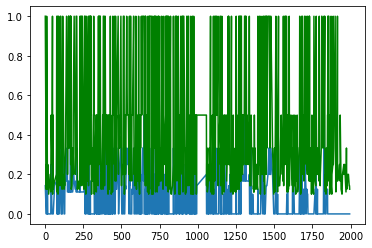

In [0]:
import scipy.stats as st
import matplotlib.pyplot as plt

test_rrs = mrr_score(imodel_best2, test_dataset)
toread_rrs = mrr_score(Combsum(num_items), test_dataset)

uids= []
y = []
x = []
for uid in np.argwhere(toread_rrs < test_rrs):
  if(toread_rrs[uid] < test_rrs[uid]):
    y.append(toread_rrs[uid].item(0))
    x.append(test_rrs[uid].item(0))
  uids.append(uid.item(0))

plt.plot(uids, y)
plt.plot(uids, x, color='g')

In [0]:
positives=ratings_df[ratings_df["rating"]>=4]

#join positives with itself on userId to get all pairs of movies watched by a given user.

pairs=pd.merge(positives, positives, on=["user_id"])

sequences=pairs[pairs["book_id_x"] < pairs["book_id_y"]] 

#lets count the frequency of each pair of movies.
paircounts=sequences[["book_id_x", "book_id_y", "user_id"]].groupby(["book_id_x", "book_id_y"]).count()

#sort by the most popular pairs.
pairswithcounts = paircounts.reset_index().rename(columns={"user_id" : "count"}).sort_values(['count'], ascending=False)

#display the top most frequent pairs
pairswithcounts.head()

,book_id_x,book_id_y,count
15,1,17,277
25705,18,27,267
25702,18,24,264
30277,21,27,256
25699,18,21,256


In [0]:
##Solution



# pairswithcounts gives is the frequency of (X AND Y). 

#We therefore need the counts of movies
bookCounts = positives.groupby(["book_id"]).count()[["user_id"]].reset_index().rename(columns={"user_id" : "ratingCount"})

#lets puts all the information in the sample dataframe.
allstats = pairswithcounts.merge(bookCounts, left_on="book_id_x", right_on="book_id").merge(bookCounts, left_on="book_id_y", right_on="book_id")

#and drop out some unused columns
allstats = allstats[["book_id_x",	"book_id_y",	"count", "ratingCount_x", "ratingCount_y"]]
allstats = allstats.loc[:,~allstats.columns.duplicated()]

#to calculate probabilites we need a denominator. I used the number of total ratings
num=float(ratings_df.count()["rating"])

#we can then perform artihmetic on columns
allstats["lift"] = (allstats["count"] / num ) / ( (allstats["ratingCount_x"] / num) * (allstats["ratingCount_y"] / num))

#and finally, merge in the titles
withtitles = allstats.merge(books_df, left_on=["book_id_x"], right_on="book_id").merge(books_df, left_on=["book_id_y"], right_on="book_id")

withtitles.sort_values(['lift'], ascending=False)

#note that some of the movies with highlest lift have very low frequencies. We would apply a minium support threshold


,book_id_x,book_id_y,count,ratingCount_x,ratingCount_y,lift,Unnamed: 0_x,book_id_x,goodreads_book_id_x,best_book_id_x,work_id_x,books_count_x,isbn_x,isbn13_x,authors_x,original_publication_year_x,original_title_x,title_x,language_code_x,average_rating_x,ratings_count_x,work_ratings_count_x,work_text_reviews_count_x,ratings_1_x,ratings_2_x,ratings_3_x,ratings_4_x,ratings_5_x,image_url_x,small_image_url_x,Unnamed: 0_y,book_id_y,goodreads_book_id_y,best_book_id_y,work_id_y,books_count_y,isbn_y,isbn13_y,authors_y,original_publication_year_y,original_title_y,title_y,language_code_y,average_rating_y,ratings_count_y,work_ratings_count_y,work_text_reviews_count_y,ratings_1_y,ratings_2_y,ratings_3_y,ratings_4_y,ratings_5_y,image_url_y,small_image_url_y
519794,1140,1302,1,1,1,124762.000000,1139,1140,5287473,5287473,5354884,53,1423121309,9.781423e+12,Rachel Hawkins,2010.0,Hex Hall,"Hex Hall (Hex Hall, #1)",eng,3.96,109881,114594,7766,2764,6358,24747,39195,41530,https://images.gr-assets.com/books/1368393885m...,https://images.gr-assets.com/books/1368393885s...,1301,1302,8235178,8235178,13082532,56,1595143971,9.781595e+12,Beth Revis,2011.0,Across the Universe,"Across the Universe (Across the Universe, #1)",eng,3.78,94176,100748,9649,3870,8338,24592,33481,30467,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
538493,418,1416,1,1,1,124762.000000,417,418,6479259,6479259,6670482,71,1595142509,9.781595e+12,Richelle Mead,2010.0,Spirit Bound,"Spirit Bound (Vampire Academy, #5)",eng,4.37,224247,235076,8030,2755,5907,26981,66097,133336,https://images.gr-assets.com/books/1291168967m...,https://images.gr-assets.com/books/1291168967s...,1415,1416,8709523,8709523,13582370,35,1595143181,9.781595e+12,Richelle Mead,2012.0,The Golden Lily,"The Golden Lily (Bloodlines, #2)",en-US,4.36,86929,91787,6026,688,1779,10687,29356,49277,https://images.gr-assets.com/books/1360599818m...,https://images.gr-assets.com/books/1360599818s...
494143,1140,1608,1,1,1,124762.000000,1139,1140,5287473,5287473,5354884,53,1423121309,9.781423e+12,Rachel Hawkins,2010.0,Hex Hall,"Hex Hall (Hex Hall, #1)",eng,3.96,109881,114594,7766,2764,6358,24747,39195,41530,https://images.gr-assets.com/books/1368393885m...,https://images.gr-assets.com/books/1368393885s...,1607,1608,7719245,7719245,6949381,39,61985848,9.780062e+12,Kiersten White,2010.0,Paranormalcy,"Paranormalcy (Paranormalcy, #1)",eng,3.91,79959,82832,5783,2417,5678,18581,26208,29948,https://images.gr-assets.com/books/1496938681m...,https://images.gr-assets.com/books/1496938681s...
494144,1302,1608,1,1,1,124762.000000,1301,1302,8235178,8235178,13082532,56,1595143971,9.781595e+12,Beth Revis,2011.0,Across the Universe,"Across the Universe (Across the Universe, #1)",eng,3.78,94176,100748,9649,3870,8338,24592,33481,30467,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,1607,1608,7719245,7719245,6949381,39,61985848,9.780062e+12,Kiersten White,2010.0,Paranormalcy,"Paranormalcy (Paranormalcy, #1)",eng,3.91,79959,82832,5783,2417,5678,18581,26208,29948,https://images.gr-assets.com/books/1496938681m...,https://images.gr-assets.com/books/1496938681s...
538398,880,1227,1,1,1,124762.000000,879,880,2800905,2800905,2451397,52,61662690,9.780062e+12,Kelley Armstrong,2008.0,The Summoning,"The Summoning (Darkest Powers, #1)",en-US,4.03,132285,136832,5830,3330,7629,27219,42153,56501,https://images.gr-assets.com/books/1478986944m...,https://images.gr-assets.com/books/1478986944s...,1226,1227,5391115,5391115,4115339,44,61662763,9.780062e+12,Kelley Armstrong,2009.0,The Awakening,"The Awakening (Darkest Powers, #2)",eng,4.16,95026,98240,3118,1151,3775,17773,31477,44064,https://images.gr-assets.com/books/1478986806m...,https://images.gr-assets.com/books/1478986806s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [0]:
class dummymodel:
  
  def __init__(self, numitems):
    self.predictions=np.zeros(numitems)
  
  #uid is the user we are requesting recommendations for;
  #returns an array of scores, one for each item
  def predict(self, uid):
    lift = allstats['lift'].sum()
    lift = np.log(lift)
lift
    #this model returns all zeros, regardless of userid
    return( self.predictions )

#lets evaluate how the effeciveness of dummymodel

print(mrr_score(dummymodel(num_items), test_dataset, train=rating_dataset, k=100).mean())
#as expected, a recommendation model that gives 0 scores for all items obtains a MRR score of 0



In [0]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(allstats, min_support=0.2, use_colnames=True, max_len=2)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=2)